# Eigenfaces: Dogs and Cats

Based on the article: L. Sirovich and M. Kirby; "Low-dimensional procedure for the characterization of human faces."

PCA: https://www.kaggle.com/code/serkanpeldek/face-recognition-on-olivetti-dataset \
Rekonstrukcja: https://towardsdatascience.com/eigenfaces-recovering-humans-from-ghosts-17606c328184

## Imports

In [1]:
import os
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import \
(accuracy_score, classification_report, confusion_matrix)

## Data collection

In [2]:
def load_images_from_folder(folder, size=(100, 100)):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.resize(img, size)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Konwersja do skali szarości
            images.append(img.flatten())
    return images


In [3]:
# Loading images of cats and dogs
cat_images = load_images_from_folder('cat', size=(100, 100))
dog_images = load_images_from_folder('dog', size=(100, 100))

In [4]:
print(len(cat_images), len(dog_images))

5558 5169


In [5]:
# Combining images of cats and dogs into one list
all_images = np.array(cat_images + dog_images)
# Creating a label list
labels = np.array([0] * len(cat_images) + [1] * len(dog_images))  # 0 = Cat, 1 = Dog
print(len(all_images))

10727


In [6]:
# Shuffling images and labels
indices = np.random.permutation(len(all_images))
all_images = all_images[indices]
labels = labels[indices]

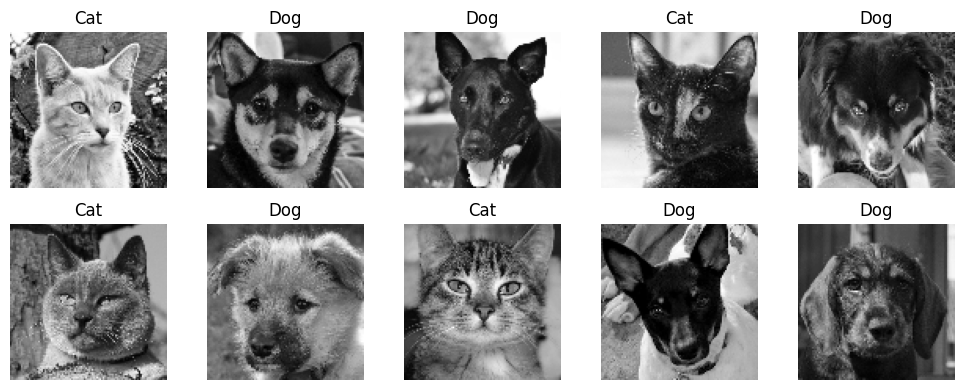

In [7]:
# Visualization of images with labels
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in enumerate(axes.flat):
    ax.imshow(all_images[i].reshape(100, 100), cmap='gray')
    ax.axis('off')
    if labels[i] == 0:
        ax.set_title('Cat')
    else:
        ax.set_title('Dog')
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.tight_layout()
plt.show()

## Data normalization and preparation

In [8]:
# Data normalization
mean_image = np.mean(all_images, axis=0)
centered_images = all_images - mean_image

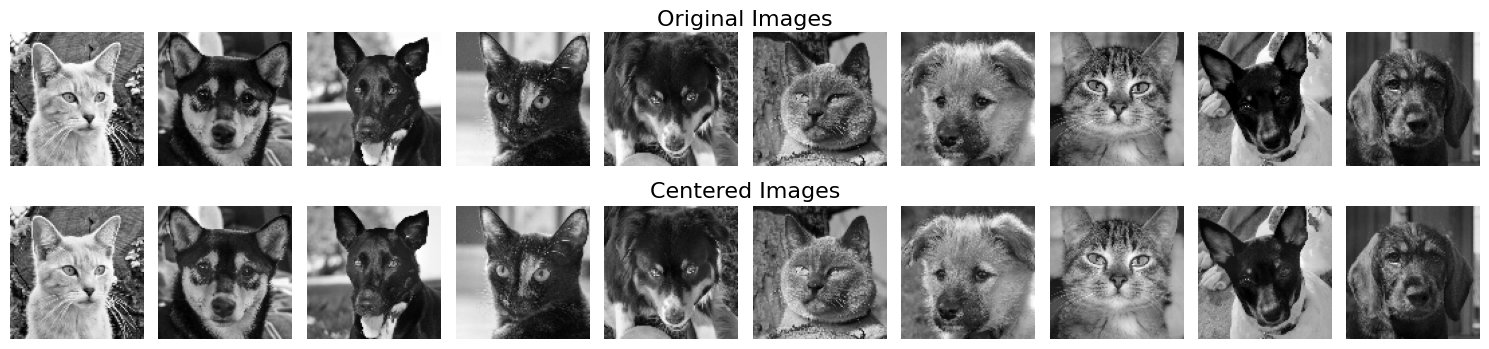

In [9]:
# Visualization of original and centered images
fig, axes = plt.subplots(2, 10, figsize=(15, 4))
for i in range(10):
    # Original images
    ax = axes[0, i]
    ax.imshow(all_images[i].reshape(100, 100), cmap='gray')
    ax.axis('off')
    # Centered images
    ax = axes[1, i]
    ax.imshow(centered_images[i].reshape(100, 100), cmap='gray')
    ax.axis('off')
fig.text(0.5, 0.9, 'Original Images', ha='center', fontsize=16)
fig.text(0.5, 0.47, 'Centered Images', ha='center', fontsize=16)
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.tight_layout()
plt.show()

## Principal Component Analysis

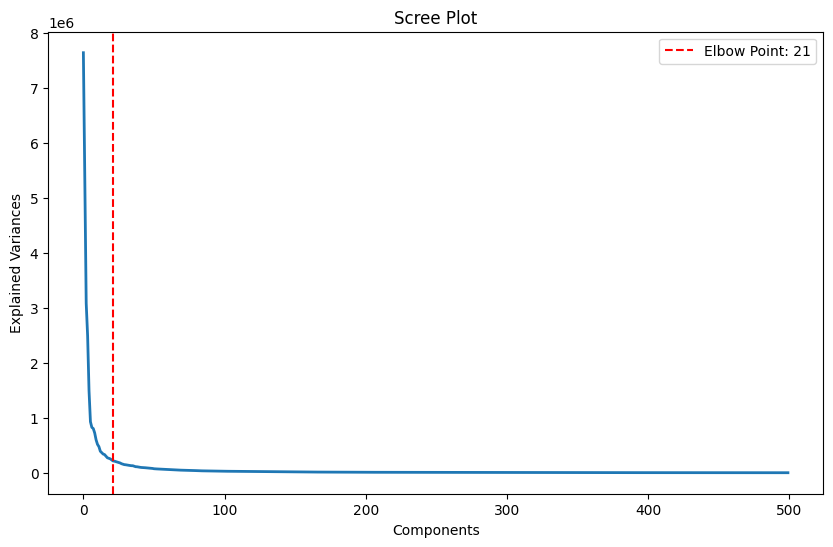

Suggested number of components: 21


In [10]:
# Finding the optimal number of principal components
pca = PCA(n_components = 500)
pca.fit(centered_images)

explained_variances = pca.explained_variance_
kl = KneeLocator(range(len(explained_variances)), explained_variances, curve='convex', direction='decreasing')
elbow_point = kl.elbow

plt.figure(1, figsize=(10,6))
plt.plot(explained_variances, linewidth=2)
plt.xlabel('Components')
plt.ylabel('Explained Variances')
plt.title('Scree Plot')
plt.axvline(x=elbow_point, color='r', linestyle='--', label=f'Elbow Point: {elbow_point}')
plt.legend()
plt.show()

print(f'Suggested number of components: {elbow_point}')

In [11]:
# Automatic selection of the number of components - UWAGA: DŁUGO TRWA
pca2 = PCA(n_components = 0.95)
pca2.fit(centered_images)
components = pca2.n_components_
print(f'Number of components explaining 95% of the variance: {components}')

Number of components explaining 95% of the variance: 964


In [12]:
# Conducting PCA
# Możemy wybrać liczbę komponentów
# 1) 95% wariancji = 964 <- ale to chyba za dużo
# 2) coś poniżej 100 -> na wykresie osypiska (scree) miejsce, gdzie krzywa się wygładza
# 2.1) +- powyżej 90 składowe reprezentują te same dane
# 2.2) obliczyliśmy punkt załamania 21 (który zmienia się jeśli zmienimy maksymalną liczbę składowych)
n_components = 50
pca = PCA(n_components = n_components)
pca.fit(centered_images)

PCA(n_components=50)

In [13]:
# Extraction of eigenfaces coefficients
eigenfaces = pca.components_.reshape((n_components, 100, 100))
transformed_images = pca.transform(centered_images) # eigenfaces coefficients

The eigenfaces coefficients are the results of the PCA transformation (transformed_images) that can be used as features for classification.

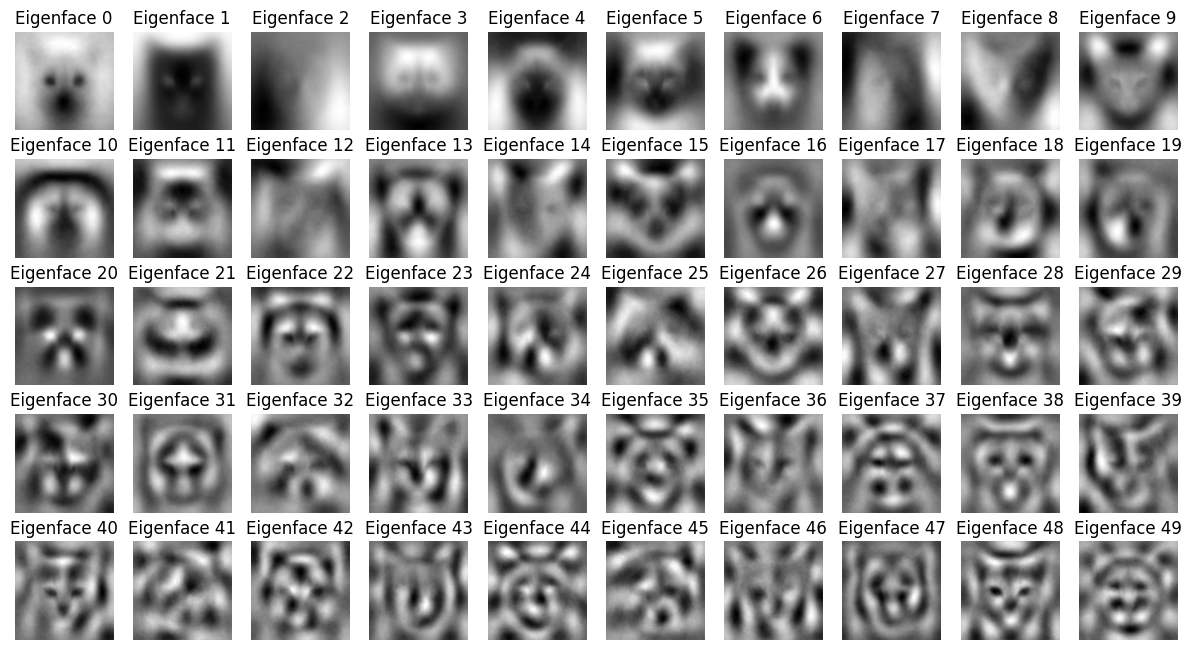

In [14]:
# Eigenfaces (principal components) visualization
fig, axes = plt.subplots(5, 10, figsize=(15, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(eigenfaces[i], cmap='gray')
    ax.set_title(f'Eigenface {i}')
    ax.axis('off')
plt.show()

## Calculation of the average image

In [15]:
# Wyświetlenie przeciętnej/średniej twarzy -> nie ma sensu, wychodzi szary obrazek, twarze są zbyt różne
# fig, ax = plt.subplots(1,1,figsize=(8,8))
# ax.imshow(pca.mean_.reshape((100,100)), cmap="gray")
# ax.set_xticks([])
# ax.set_yticks([])
# ax.set_title('Average Face')

## Image reconstruction

In [16]:
# Image reconstruction
reconstructed_images = pca.inverse_transform(pca.transform(centered_images))
reconstructed_images = reconstructed_images.reshape((-1, 100, 100))

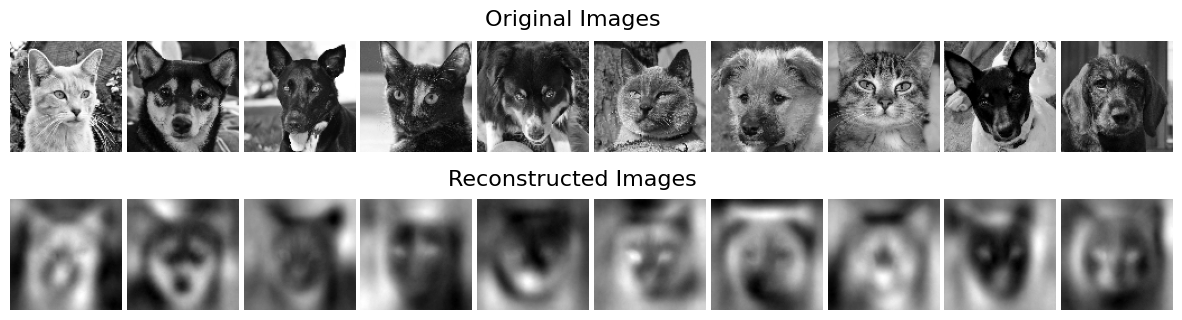

In [17]:
# Visualization of original and reconstructed images
fig, axes = plt.subplots(2, 10, figsize=(15, 4))
for i in range(10):
    # Original images
    ax = axes[0, i]
    ax.imshow(all_images[i].reshape(100, 100), cmap='gray')
    ax.axis('off')
    # Reconstructed images
    ax = axes[1, i]
    ax.imshow(reconstructed_images[i], cmap='gray')
    ax.axis('off')
fig.text(0.5, 0.87, 'Original Images', ha='center', fontsize=16)
fig.text(0.5, 0.47, 'Reconstructed Images', ha='center', fontsize=16)
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()

---

### n_components = 964

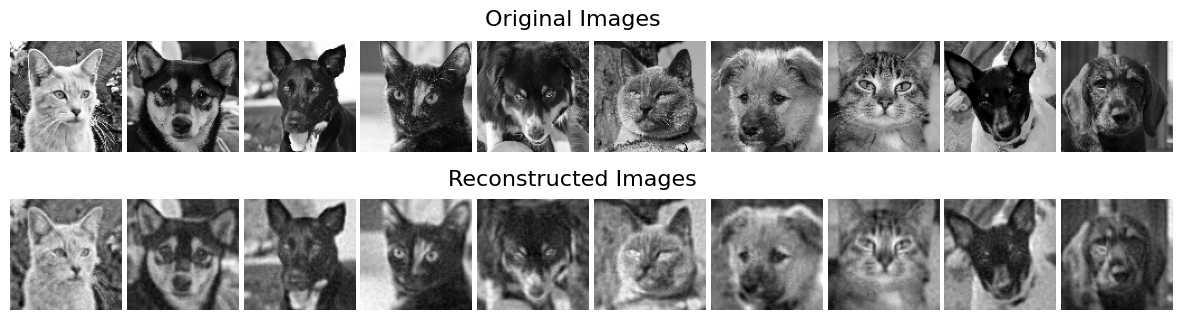

In [18]:
eigenfaces2 = pca2.components_.reshape((components, 100, 100))
# Image reconstruction
reconstructed_images2 = pca2.inverse_transform(pca2.transform(centered_images))
reconstructed_images2 = reconstructed_images2.reshape((-1, 100, 100))
# Visualization of original and reconstructed images
fig, axes = plt.subplots(2, 10, figsize=(15, 4))
for i in range(10):
    # Original images
    ax = axes[0, i]
    ax.imshow(all_images[i].reshape(100, 100), cmap='gray')
    ax.axis('off')
    # Reconstructed images
    ax = axes[1, i]
    ax.imshow(reconstructed_images2[i], cmap='gray')
    ax.axis('off')
fig.text(0.5, 0.87, 'Original Images', ha='center', fontsize=16)
fig.text(0.5, 0.47, 'Reconstructed Images', ha='center', fontsize=16)
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()

---

## Classification

In [19]:
# Splitting the data into a training and test set - dla [:500] już działa długo, a mamy 10727 obrazków
# X_train, X_test, y_train, y_test = train_test_split(transformed_images, labels, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(transformed_images[:500], labels[:500], test_size=0.2, random_state=42)

In [20]:
# Testing various model parameters
# from sklearn.model_selection import GridSearchCV

# # Preparing a grid of parameters to be tested
# param_grid = {
#     'C': [0.1, 1, 10],
#     'kernel': ['linear', 'rbf'],
#     'gamma': [0.001, 0.01, 0.1, 1],
#     'degree': [2, 3, 4],
#     'coef0': [0.0, 0.1, 0.5]
# }

# # Creating the GridSearchCV object
# grid_search = GridSearchCV(estimator=SVC(random_state=42),
#                            param_grid=param_grid,
#                            scoring='accuracy',
#                            cv=5,
#                            verbose=1,
#                            n_jobs=-1)

# # Searching the parameter grid
# grid_search.fit(X_train, y_train)

# # Choosing the best model
# best_svm = grid_search.best_estimator_

# # Display of the best parameters
# print("The best SVM parameters:")
# print(grid_search.best_params_)

# # Evaluation on the test set
# y_pred = best_svm.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)
# print(f"Accuracy on the test set: {accuracy * 100:.2f}%")
# {'C': 0.1, 'coef0': 0.0, 'degree': 2, 'gamma': 0.001, 'kernel': 'linear'}

In [21]:
# Training the SVM model - bez grid search cv, bo dla zbioru obrazków > 100 działa za długo
best_svm = SVC(kernel='linear', C=0.1, random_state=42)
best_svm.fit(X_train, y_train)

SVC(C=0.1, kernel='linear', random_state=42)

In [22]:
# Prediction on the test set
y_pred = best_svm.predict(X_test)

In [23]:
# Model evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print("Classification report:\n", classification_report(y_test, y_pred, target_names=['Cat', 'Dog']))

Accuracy: 75.00%
Classification report:
               precision    recall  f1-score   support

         Cat       0.80      0.73      0.77        56
         Dog       0.69      0.77      0.73        44

    accuracy                           0.75       100
   macro avg       0.75      0.75      0.75       100
weighted avg       0.76      0.75      0.75       100



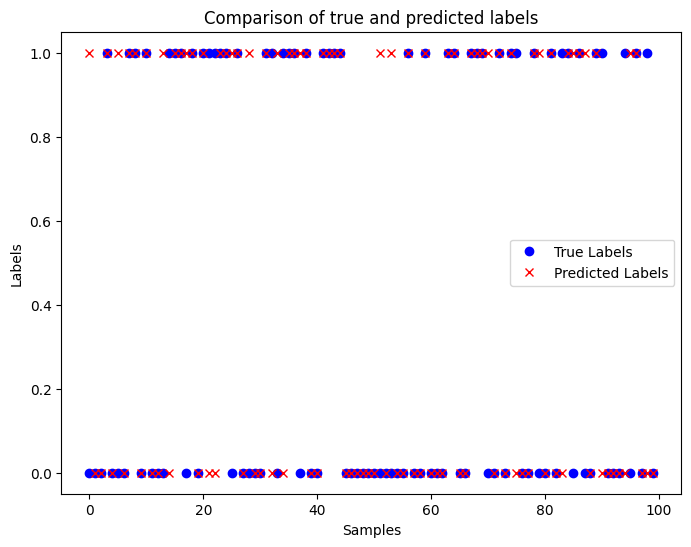

In [24]:
# Accuracy chart - śmieszny wykres, dla większej liczby danych nieczytelny
plt.figure(figsize=(8, 6))
plt.plot(range(len(y_test)), y_test, label='True Labels', marker='o', linestyle='None', color='b')
plt.plot(range(len(y_test)), y_pred, label='Predicted Labels', marker='x', linestyle='None', color='r')
plt.title('Comparison of true and predicted labels')
plt.xlabel('Samples')
plt.ylabel('Labels')
plt.legend()
plt.show()

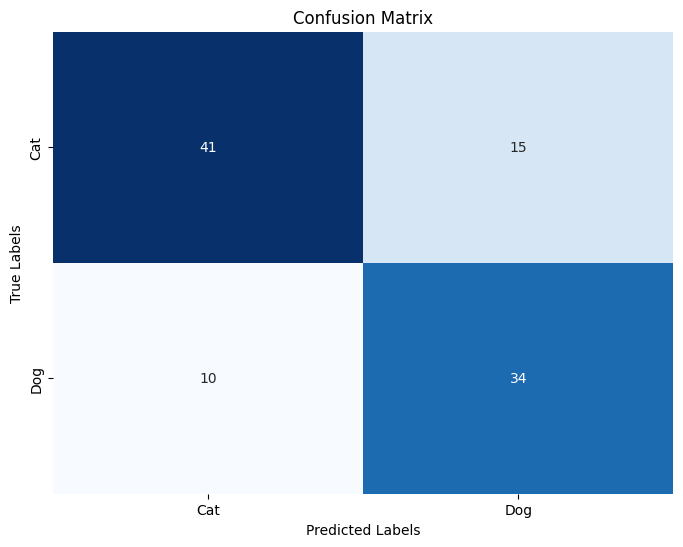

In [25]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False,
           xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

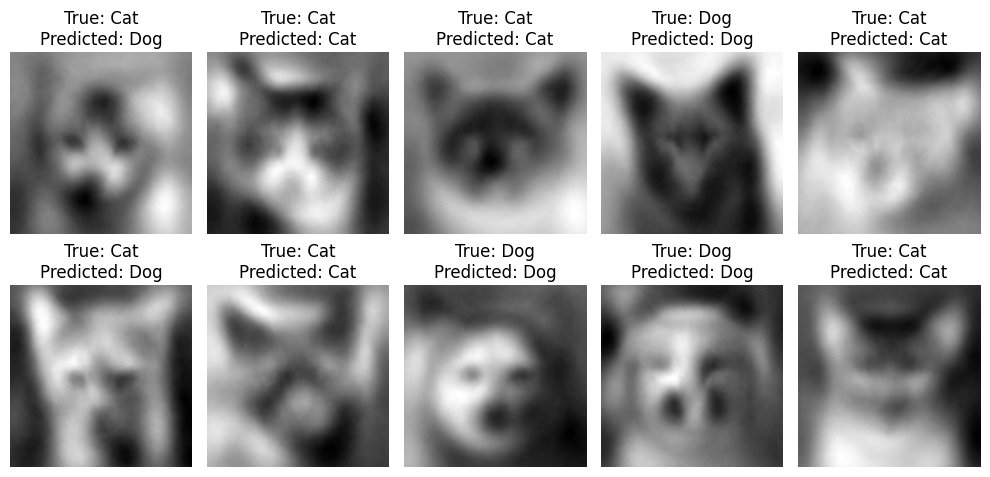

In [26]:
# Reconstructing images from reduced dimensions
test_images = pca.inverse_transform(X_test)

# Visualization of images with real and predicted labels
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(test_images[i].reshape(100, 100), cmap='gray')
    ax.axis('off')
    if y_pred[i] == 0:
        pred_label = 'Cat'
    else:
        pred_label = 'Dog'
    if y_test[i] == 0:
        true_label = 'Cat'
    else:
        true_label = 'Dog'
    ax.set_title(f'True: {true_label}\nPredicted: {pred_label}')
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.tight_layout()
plt.show()

## Code summary:
- Image loading and processing: Load cat and dog images, reduce size to 100x100 pixels and convert to grayscale.
- Data preparation: Calculate the average image and convert the images into a deviation matrix.
- PCA: Perform PCA to obtain principal components (eigenfaces) and transform the images into eigenfaces coefficients.
- Classification: Splitting data into training and testing sets, training the SVM model on eigenfaces coefficients, model prediction and evaluation.